In [644]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os
from WindPy import w
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy import stats
%matplotlib inline

In [2]:
DATA_DIR = 'D:/Data/stocks'
COST_DIR = 'D:/Data/avg_cost/by stock'

In [485]:
ticker = '000402.SZ'

In [486]:
fname = '%s/%s.xlsx'%(DATA_DIR, ticker)
df = pd.read_excel(fname, index_col=0)

In [487]:
df.tail()

,amt,close,dealnum,free_turn,mfd_buyamt_a,mfd_sellamt_a,mkt_freeshares,turnover,volume,vwap
2017-03-28 00:00:00.005,1.238359e+08,11.10,4376,0.552669,15826848.0,11160921.0,2.246347e+10,0.005513,11184560.0,11.072044
2017-03-29 00:00:00.005,1.134865e+08,11.01,5726,0.507399,4082796.0,12829077.0,2.228134e+10,0.005093,10268408.0,11.052009
2017-03-30 00:00:00.005,1.342319e+08,10.88,9045,0.606655,4274777.0,11387552.0,2.201825e+10,0.006096,12277089.0,10.933525
2017-03-31 00:00:00.005,1.051114e+08,11.08,7006,0.472287,7477950.0,2489416.0,2.242300e+10,0.004688,9557848.0,10.997396
2017-04-05 00:00:00.005,1.315457e+09,11.96,44279,5.446351,188063558.0,198543387.0,2.420389e+10,0.054349,110219786.0,11.934858


In [488]:
fname = '%s/%s.xlsx'%(COST_DIR, ticker)
cost_df = pd.read_excel(fname, index_col=0)

In [489]:
cost_df.tail()

,turnover days,avg cost,close
2017-03-28 00:00:00.005,160.0,11.309081,11.10
2017-03-29 00:00:00.005,160.0,11.310326,11.01
2017-03-30 00:00:00.005,161.0,11.308154,10.88
2017-03-31 00:00:00.005,161.0,11.309575,11.08
2017-04-05 00:00:00.005,159.0,11.354105,11.96


# 某一天的筹码分布

In [461]:
def cost_distribution(ticker, date):
    fname = '%s/%s.xlsx'%(DATA_DIR, ticker)
    df = pd.read_excel(fname, index_col=0)
    fname = '%s/%s.xlsx'%(COST_DIR, ticker)
    cost_df = pd.read_excel(fname, index_col=0)
    
    turnover_days = cost_df[cost_df.index >= date]['turnover days'][0]
    avg_cost = cost_df[cost_df.index >= date]['avg cost'][0]
    close = cost_df[cost_df.index >= date]['close'][0]
    day = cost_df[cost_df.index >= date].index[0]
    
    start_day = cost_df.index[int(cost_df.index.get_loc(day) - turnover_days)]
    select_df = df[(df.index >= start_day) & (df.index <= day)]
    
    dic = {}
    for vwap, volume in zip(select_df['vwap'], select_df['volume']):
        cost = '%.2f'%(vwap)
        if not dic.has_key(cost):
            dic[cost] = 0
        dic[cost] += volume
    dic = {'cost': dic.keys(), 'vol': dic.values()}
    res_df = pd.DataFrame(dic)
    res_df['cost'] = res_df['cost'].astype(float)
    res_df = res_df.sort_values('cost')
    print("average cost=%.2f\tclose price=%.2f"%(avg_cost, close))
    plt.figure(figsize=(16, 9))
    ax = sns.barplot(x='cost', y='vol', data=res_df)
    for item in ax.get_xticklabels():
        item.set_rotation(45)

average cost=4.29	close price=4.28


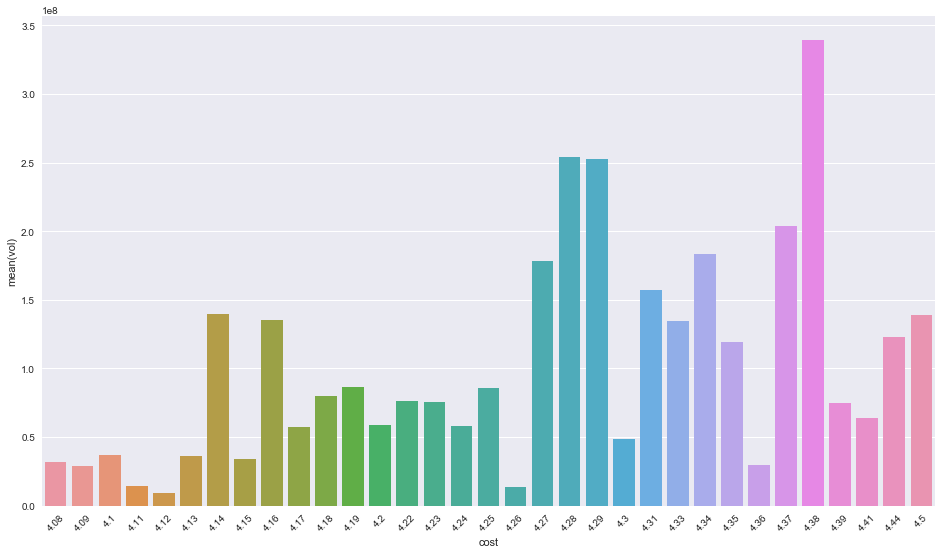

In [462]:
cost_distribution('600008.SH', '2017-03-29')

average cost=4.29	close price=4.22


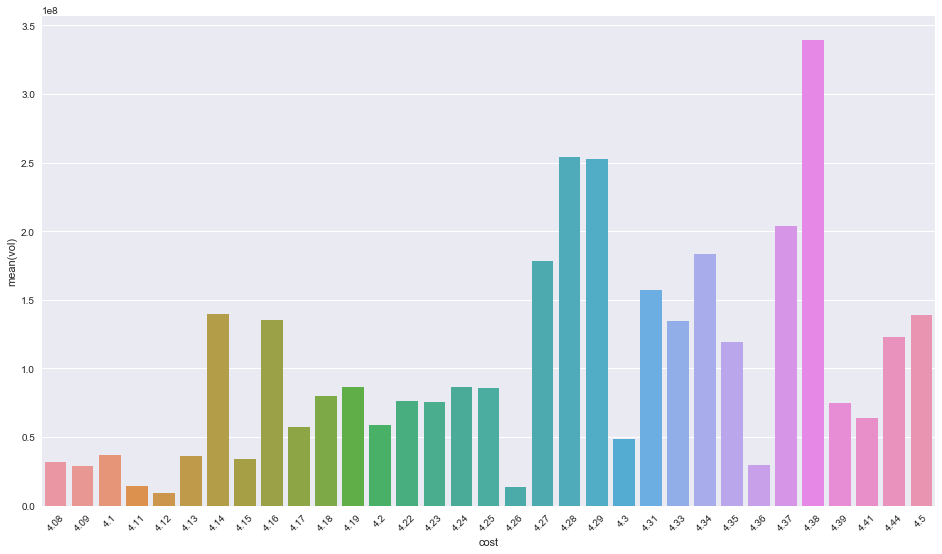

In [463]:
cost_distribution('600008.SH', '2017-03-30')

# 盈利持仓占比

In [490]:
df = pd.concat([df, cost_df[['turnover days', 'avg cost']]], axis=1)

In [491]:
df.loc[:, 'profit percentage'] = np.nan
for index in df.index:
    turnover_days = df.loc[index, 'turnover days']
    current_price = df.loc[index, 'close']
    if not np.isnan(turnover_days):
        if pos > 0:
            start_day = index - datetime.timedelta(turnover_days)
            select_df = df[(df.index >= start_day) & (df.index <= index)]
            profit_volume = select_df[select_df['vwap'] < current_price]['volume'].sum()
            df.loc[index, 'profit percentage'] = profit_volume / select_df['volume'].sum()

In [477]:
df = df[df.index >= '2016-03-01']

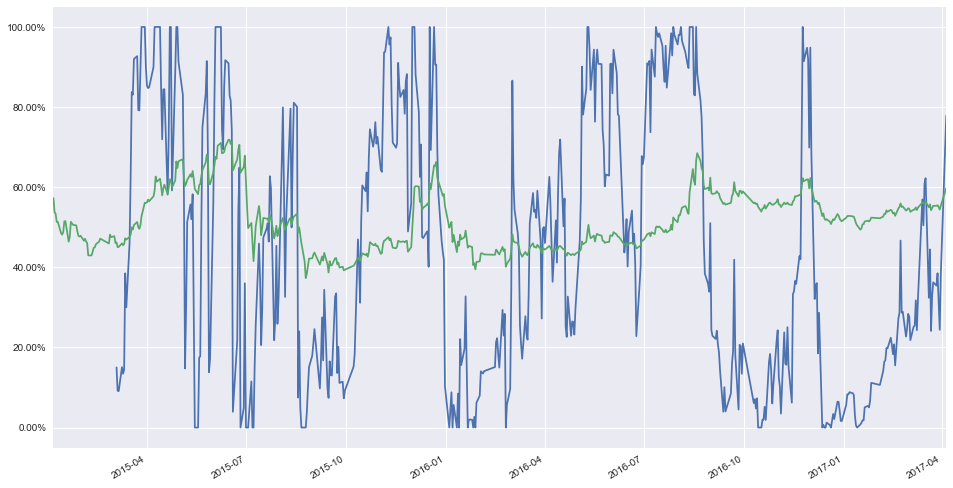

In [492]:
plt.figure(figsize=(16, 9))
ax = df['profit percentage'].plot()
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])
(df['close'] / 20).plot()

In [450]:
df['profit percentage'].tail(n=10)

2017-03-21 00:00:00.005    0.625620
2017-03-22 00:00:00.005    0.461234
2017-03-23 00:00:00.005    0.412883
2017-03-24 00:00:00.005    0.548780
2017-03-27 00:00:00.005    0.528001
2017-03-28 00:00:00.005    0.401692
2017-03-29 00:00:00.005    0.403417
2017-03-30 00:00:00.005    0.296003
2017-03-31 00:00:00.005    0.376805
2017-04-05 00:00:00.005         NaN
Name: profit percentage, dtype: float64

# 全市场盈利占比

In [494]:
files = [f for f in os.listdir(COST_DIR)]

In [496]:
dic = {}
for f in files:
    fname = '%s/%s'%(COST_DIR, f)
    df = pd.read_excel(fname, index_col=0)
    dic[f[:-5]] = df
pnl = pd.Panel(dic)

In [502]:
def wind2df(raw_data):
    dic = {}
    for data, field in zip(raw_data.Data, raw_data.Fields):
        dic[str(field.lower())] = data
    return pd.DataFrame(dic, index=raw_data.Times)

In [505]:
w.start()

Welcome to use Wind Quant API for Python (WindPy)!
You can use w.menu to help yourself to create commands(WSD,WSS,WST,WSI,WSQ,...)!

COPYRIGHT (C) 2016 WIND HONGHUI INFORMATION & TECHKNOLEWDGE CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

In [520]:
data = w.wsd('881001.WI', 'close', '2015-01-01', '2017-04-05')

In [634]:
df = wind2df(data)

# 验证有效性

In [635]:
df['profit'] = pnl.ix[:, :, 'profit percentage'].mean(axis=1)

In [636]:
df = df[df.index >= '2016-03-01']

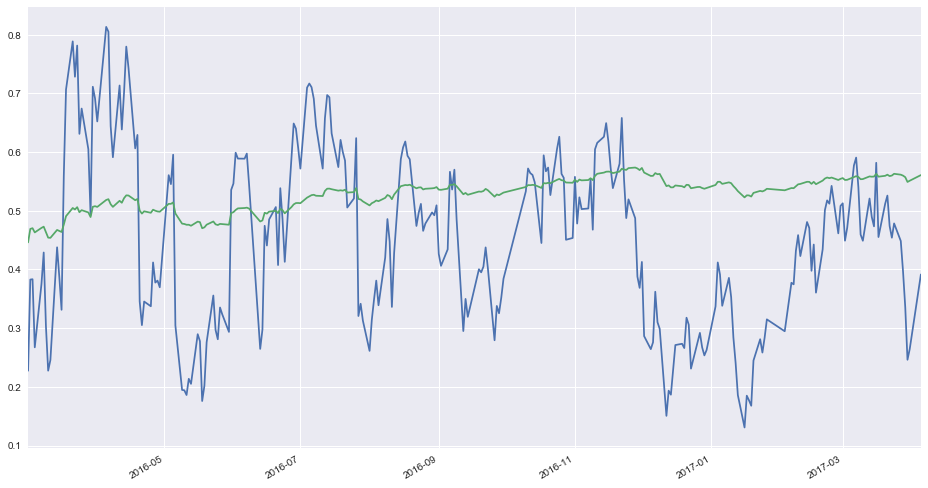

In [637]:
plt.figure(figsize=(16, 9))
df['profit'].plot()
(df['close'] / 8000).plot()

In [682]:
df.loc[:, 'return'] = df.loc[:, 'close'].pct_change(40)

In [683]:
df.loc[:, 'y'] = df.loc[:, 'return'].shift(-39)

In [684]:
df['y'].corr(df['profit'])

-0.47237711918015707

In [685]:
x, y = df.dropna()['profit'], df.dropna()['y']
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

In [686]:
slope, intercept, r_value, p_value, std_err

(-0.11139917660081465,
 0.075386628607952103,
 -0.35482996157081786,
 5.4509286404809139e-07,
 0.021464480648254035)

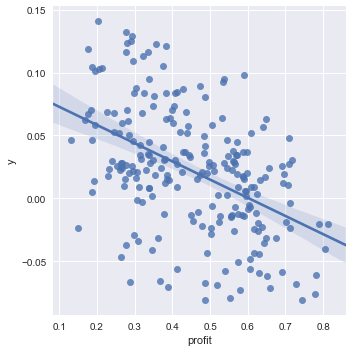

In [687]:
plt.figure(figsize=(16, 9))
sns.lmplot(x='profit', y='y', data=df)

In [576]:
corrs = []
for k in range(1, 60):
    if k % 10 == 0:
        print k
    df.loc[:, 'return'] = df.loc[:, 'close'].pct_change(k)
    df.loc[:, 'y'] = df.loc[:, 'return'].shift(-k)
    corrs.append(df['y'].corr(df['profit']))

10
20
30
40
50


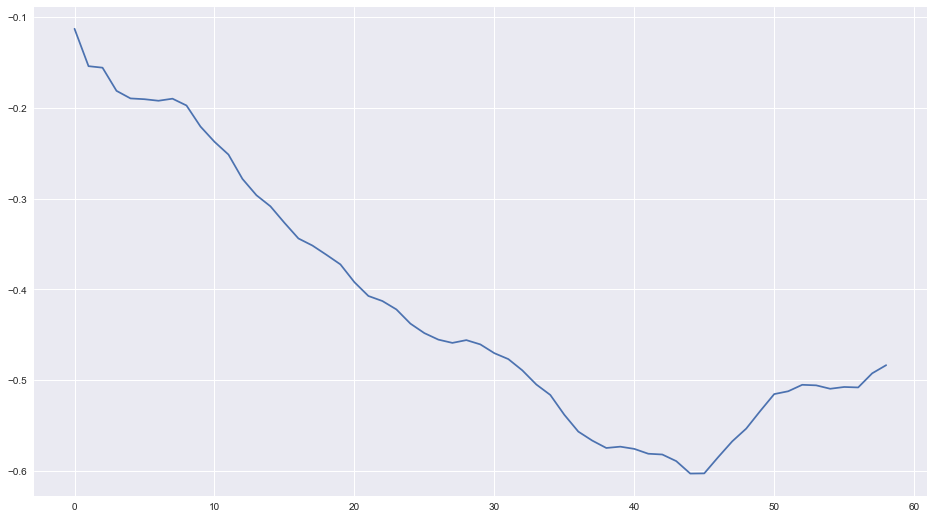

In [577]:
plt.figure(figsize=(16, 9))
plt.plot(corrs)